# Testing
### Median-Einkommen steuerpflichtiger natürlicher Personen nach Jahr, Steuertarif und Stadtquartier.


Datum: 03.02.2022

**Importiere die notwendigen Packages**

In [216]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [217]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [218]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

Importiere einen Datensatz von der **DWH_INT** Dropzone.

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**: https://data.integ.stadt-zuerich.ch/dataset/int_dwh_fd_median_einkommen_quartier_od1003

In [219]:
# Filepath
fp = r"//szh.loc/ssz/applikationen/OGD_Dropzone/INT_DWH/fd_median_einkommen_quartier_OD1003/WIR100OD1003.csv"

# Read the data
data2betested = pd.read_csv(
    fp, 
    sep=',',
   parse_dates=['SteuerJahr'],
    #date_parser=lambda x: pd.to_datetime(x, format="%Y"), 
    #index_col="date_time",
    low_memory=False    
    )
print("done")

done


In der Folge ein paar erste Tests:

In [220]:
type(data2betested)

pandas.core.frame.DataFrame

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [221]:
data2betested

,SteuerJahr,QuarSort,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerEinkommen_p50,SteuerEinkommen_p25,SteuerEinkommen_p75
0,1999-01-01,11,Rathaus,0,Grundtarif,40,19,65
1,1999-01-01,11,Rathaus,1,Verheiratetentarif,80,48,128
2,1999-01-01,11,Rathaus,2,Einelternfamilientarif,43,24,87
3,1999-01-01,12,Hochschulen,0,Grundtarif,31,12,55
4,1999-01-01,12,Hochschulen,1,Verheiratetentarif,86,52,177
...,...,...,...,...,...,...,...,...
2137,2019-01-01,122,Schwamendingen-Mitte,1,Verheiratetentarif,63,40,90
2138,2019-01-01,122,Schwamendingen-Mitte,2,Einelternfamilientarif,30,10,48
2139,2019-01-01,123,Hirzenbach,0,Grundtarif,33,12,52
2140,2019-01-01,123,Hirzenbach,1,Verheiratetentarif,62,41,86


In [222]:
data2betested.dtypes

SteuerJahr             datetime64[ns]
QuarSort                        int64
QuarLang                       object
SteuerTarifSort                 int64
SteuerTarifLang                object
SteuerEinkommen_p50           float64
SteuerEinkommen_p25           float64
SteuerEinkommen_p75           float64
dtype: object

In [223]:
data2betested.shape

(2142, 8)

Beschreibe einzelne Attribute

In [224]:
data2betested.describe()

,QuarSort,SteuerTarifSort,SteuerEinkommen_p50,SteuerEinkommen_p25,SteuerEinkommen_p75
count,2142,2142,2081,2081,2081
mean,65,1,59,33,92
std,36,1,27,19,46
min,11,0,25,0,40
25%,33,0,40,20,61
50%,67,1,50,26,77
75%,92,2,68,45,102
max,123,2,172,108,293


Wie viele Nullwerte gibt es im Datensatz?

In [225]:
data2betested.isnull().sum()

SteuerJahr              0
QuarSort                0
QuarLang                0
SteuerTarifSort         0
SteuerTarifLang         0
SteuerEinkommen_p50    61
SteuerEinkommen_p25    61
SteuerEinkommen_p75    61
dtype: int64

Hier kommen NaN vor, aber nur bei Einelterntarifen:

In [226]:
check = data2betested.query('SteuerEinkommen_p50.isnull() and SteuerTarifLang == "Einelternfamilientarif"')
check

,SteuerJahr,QuarSort,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerEinkommen_p50,SteuerEinkommen_p25,SteuerEinkommen_p75
5,1999-01-01,12,Hochschulen,2,Einelternfamilientarif,NaN,NaN,NaN
8,1999-01-01,13,Lindenhof,2,Einelternfamilientarif,NaN,NaN,NaN
11,1999-01-01,14,City,2,Einelternfamilientarif,NaN,NaN,NaN
107,2000-01-01,12,Hochschulen,2,Einelternfamilientarif,NaN,NaN,NaN
110,2000-01-01,13,Lindenhof,2,Einelternfamilientarif,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1946,2018-01-01,13,Lindenhof,2,Einelternfamilientarif,NaN,NaN,NaN
1949,2018-01-01,14,City,2,Einelternfamilientarif,NaN,NaN,NaN
2045,2019-01-01,12,Hochschulen,2,Einelternfamilientarif,NaN,NaN,NaN
2048,2019-01-01,13,Lindenhof,2,Einelternfamilientarif,NaN,NaN,NaN


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [227]:
data2betested = (
    data2betested
    .copy()
    .assign(
        SteuerJahr_str= lambda x: x.SteuerJahr.astype(str),
    )
    )
data2betested.dtypes

SteuerJahr             datetime64[ns]
QuarSort                        int64
QuarLang                       object
SteuerTarifSort                 int64
SteuerTarifLang                object
SteuerEinkommen_p50           float64
SteuerEinkommen_p25           float64
SteuerEinkommen_p75           float64
SteuerJahr_str                 object
dtype: object

In [228]:
data2betested = data2betested.set_index("SteuerJahr")

In [229]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2142 entries, 1999-01-01 to 2019-01-01
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   QuarSort             2142 non-null   int64  
 1   QuarLang             2142 non-null   object 
 2   SteuerTarifSort      2142 non-null   int64  
 3   SteuerTarifLang      2142 non-null   object 
 4   SteuerEinkommen_p50  2081 non-null   float64
 5   SteuerEinkommen_p25  2081 non-null   float64
 6   SteuerEinkommen_p75  2081 non-null   float64
 7   SteuerJahr_str       2142 non-null   object 
dtypes: float64(3), int64(2), object(3)
memory usage: 150.6+ KB


Int64Index([1], dtype='int64', name='SteuerJahr')

Wandle die Spalte Jahr von Int zu **Datetime** um. Dies wird in den meisten Grafiken so benötigt.

Bereite die Daten für die Grafik unten vor

In [230]:
Jahre = data2betested.groupby("SteuerJahr")
len(Jahre)

21

**Selektionen und Aggregationen**

Check this [Doku](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)

**Einfache Visualisierungen zur Plausi**

Exploriere die Daten mit Pivottable.JS

In [231]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

In [232]:
#data2betested.dtypes

In [233]:
myGraph = data2betested[['QuarLang','QuarSort','SteuerTarifLang','SteuerEinkommen_p50']].query('QuarSort > 0').loc["2019"].reset_index().sort_values('QuarSort', ascending = False)

In [234]:
myTitle="Medianeinkommen nach Stadtquartier, 2019"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['SteuerTarifLang'], nearest=True)

base = alt.Chart(myGraph,title=myTitle ).encode(
    x=alt.X('QuarLang', axis=alt.Axis(title='Stadtquartier'))
    ,y=alt.X('SteuerEinkommen_p50', axis=alt.Axis(title='Medianeinkommen p50'))
    , color=alt.Color('SteuerTarifLang', legend=alt.Legend(title="Steuertarif:", orient="right"))  
    ,tooltip=['SteuerJahr', 'QuarLang','SteuerEinkommen_p50', 'SteuerTarifLang']       
)

points = base.mark_circle().encode(
    opacity=alt.value(0)
).add_selection(
    highlight
).properties(
    width=700 , height=300
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()

points + lines



alt.LayerChart(...)

Text(0.5, 0.98, 'Medianeinkommen nach Stadtquartier (alleTarife)')

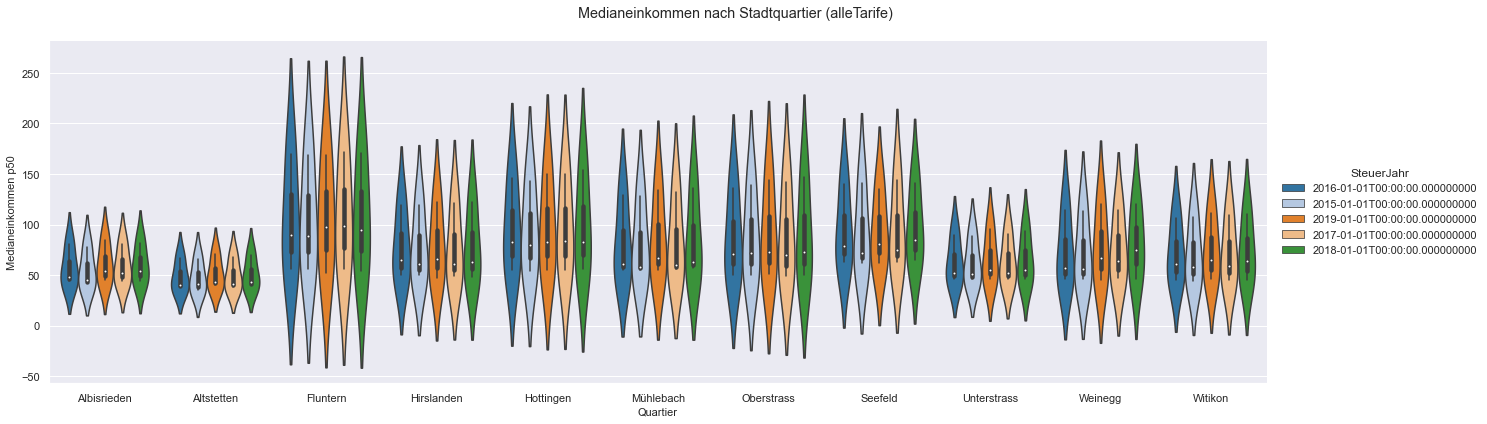

In [237]:
myTitle="Medianeinkommen nach Stadtquartier (alleTarife)"

#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="QuarLang"
            , y="SteuerEinkommen_p50"
            , hue="SteuerJahr"
            , kind="violin" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="tab20" #, color="green" 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r',
            , height=6
            , aspect=3
            , edgecolor= None
            , order=None, legend_out=True
            ,data=data2betested[['SteuerJahr_str', 'QuarLang','QuarSort','SteuerTarifLang','SteuerEinkommen_p50']]
                     .query('QuarSort > 60 & QuarSort < 100').loc["2015":"2019"]
                     .reset_index().sort_values('QuarLang', ascending = True)
           )
myHist.set_xticklabels(rotation=0)
myHist.set_xlabels('Quartier', fontsize=11) # not set_label
myHist.set_ylabels('Medianeinkommen p50', fontsize=11)

myHist.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
myHist.fig.suptitle(myTitle)

In [238]:
theGrid = data2betested[['SteuerJahr_str', 'QuarLang','QuarSort','SteuerTarifLang','SteuerEinkommen_p50']].query('QuarSort > 0').loc["1999":"2019"].reset_index().sort_values('QuarLang', ascending = True)

Text(0.5, 0.98, 'Medianeinkommen nach Steuertarif, Stadtquartier und Jahr')

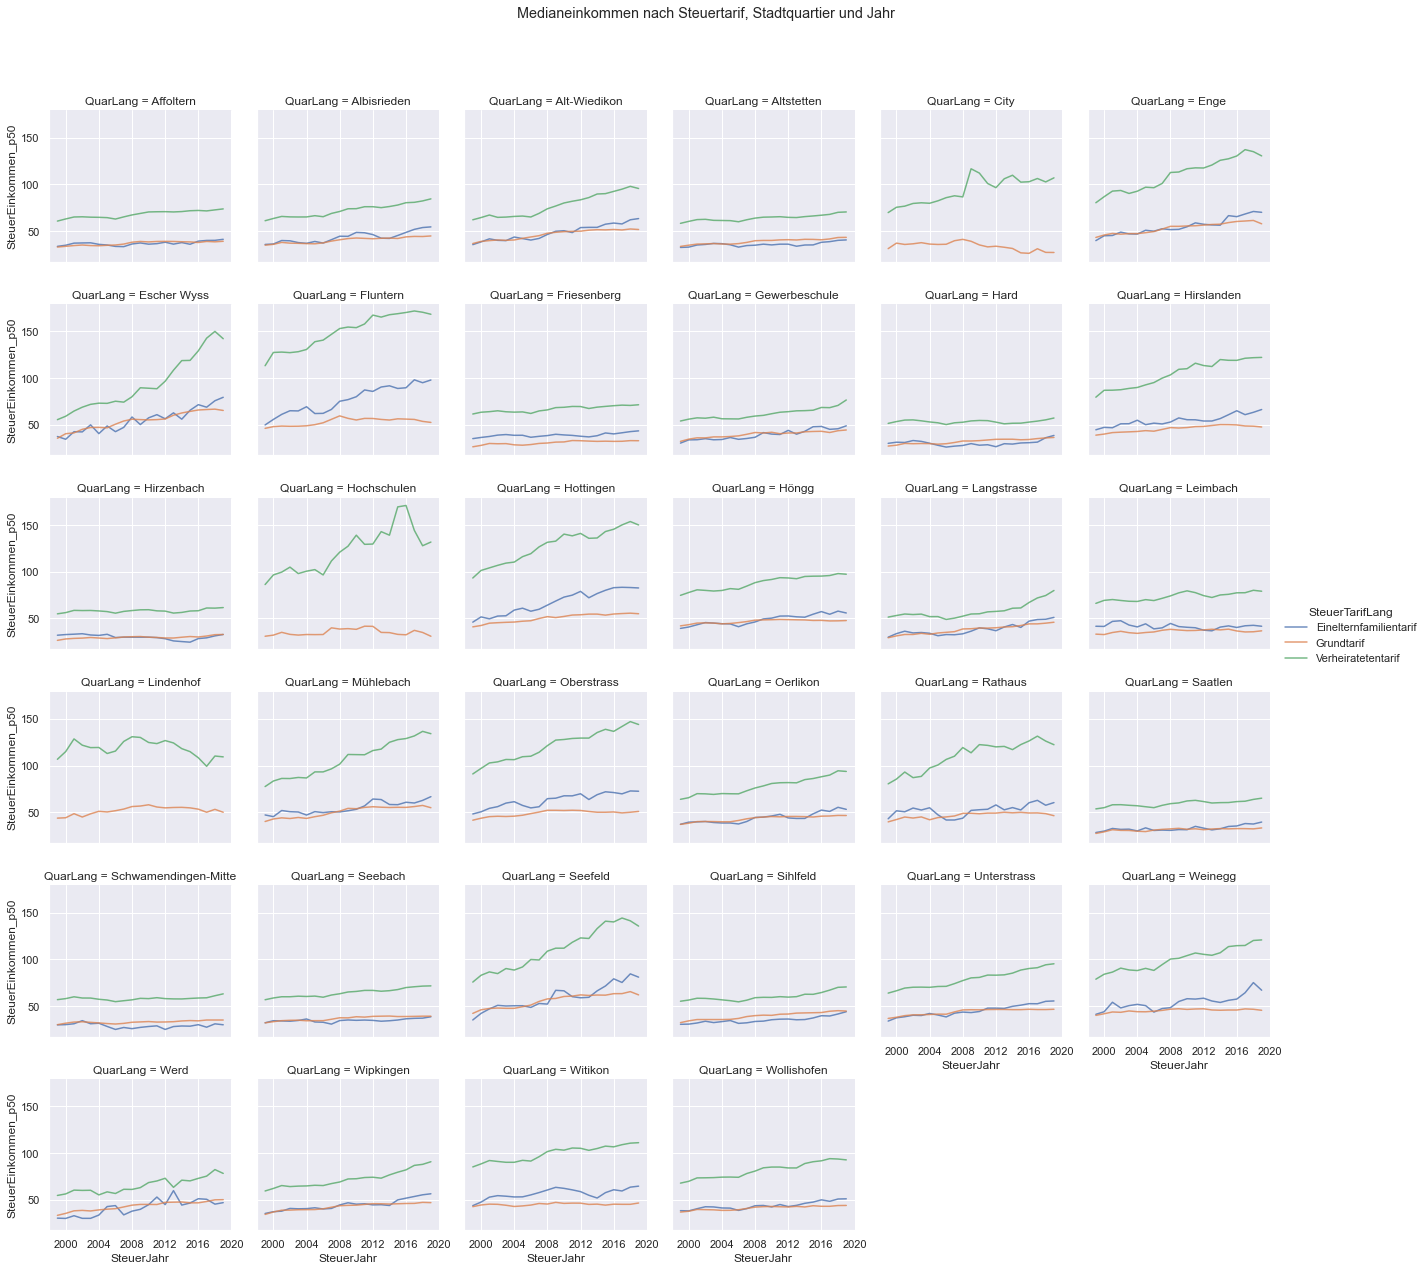

In [239]:
myTitle="Medianeinkommen nach Steuertarif, Stadtquartier und Jahr"

g = sns.FacetGrid(theGrid.reset_index(), col="QuarLang", hue="SteuerTarifLang", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "Jahr", "sum_AnzWhg", alpha=.8)
g.map(sns.lineplot, "SteuerJahr","SteuerEinkommen_p50", alpha=.8)
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(myTitle)


In [241]:
theGrid = data2betested[['SteuerJahr_str', 'QuarLang','QuarSort','SteuerTarifLang','SteuerEinkommen_p75']].query('QuarSort > 0').loc["1999":"2019"].reset_index().sort_values('QuarLang', ascending = True)

Text(0.5, 0.98, 'P75-einkommen nach Steuertarif, Stadtquartier und Jahr')

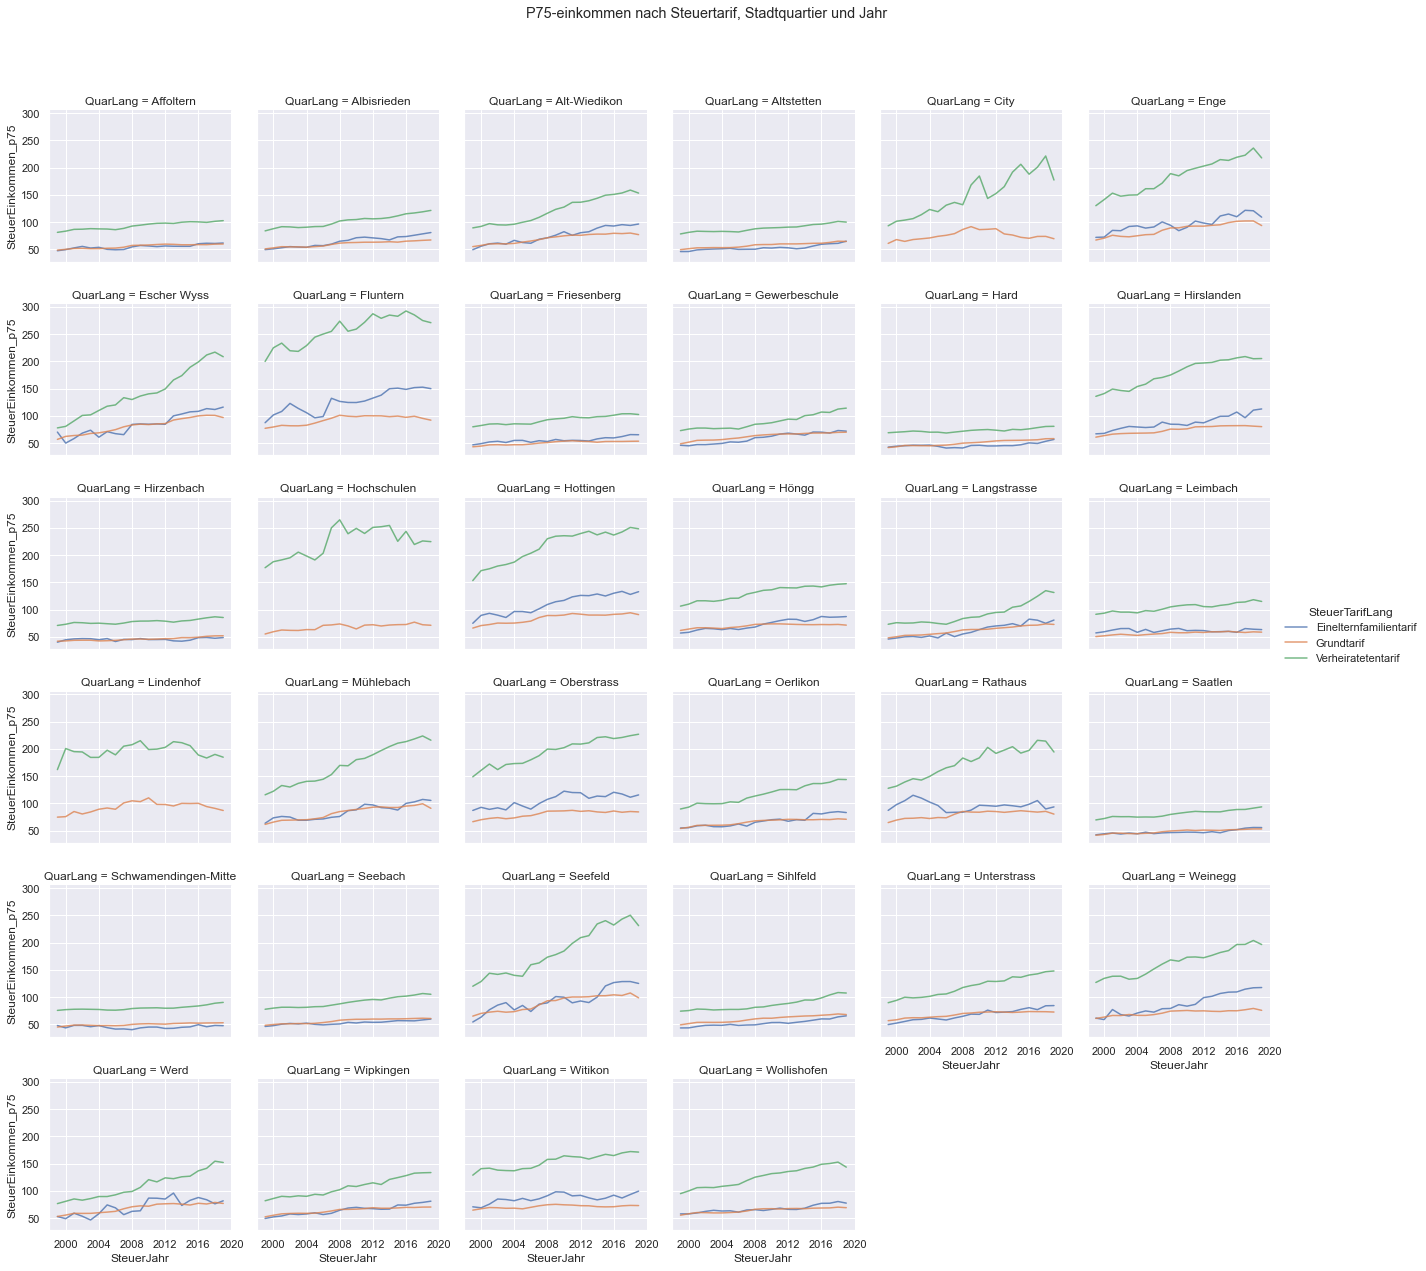

In [242]:
myTitle="P75-einkommen nach Steuertarif, Stadtquartier und Jahr"

g = sns.FacetGrid(theGrid.reset_index(), col="QuarLang", hue="SteuerTarifLang", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "Jahr", "sum_AnzWhg", alpha=.8)
g.map(sns.lineplot, "SteuerJahr","SteuerEinkommen_p75", alpha=.8)
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(myTitle)

Test: Choroplethenkarte

**Test: Choroplethenkarte**
Importiere die Geodaten als GeoJSON

In [243]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
# Filepath statzonen
geojson_url = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url)

df_adm_statistische_quartiere_map.head(5)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."
2,adm_statistische_quartiere_map.3,Kreis 8,8,3,32,Mühlebach,82,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ..."
3,adm_statistische_quartiere_map.4,Kreis 8,8,4,31,Seefeld,81,"POLYGON ((8.54795 47.36500, 8.54805 47.36489, ..."
4,adm_statistische_quartiere_map.7,Kreis 4,4,7,16,Werd,41,"POLYGON ((8.53300 47.37394, 8.53299 47.37392, ..."


Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [248]:
selectMapAttr1 = data2betested.loc["2019"].query('SteuerTarifLang=="Grundtarif"')
selectMapAttr2 = data2betested.loc["2019"].query('SteuerTarifLang=="Verheiratetentarif"')


In [250]:
selectMapAttr1.head(1)


,QuarSort,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerEinkommen_p50,SteuerEinkommen_p25,SteuerEinkommen_p75,SteuerJahr_str
SteuerJahr,,,,,,,,
2019-01-01,11,Rathaus,0,Grundtarif,46,18,80,2019-01-01


In [251]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name

stadtquartiere_shapes = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarSort'})

# Merge with `merge` method on shared variable (stznr und StatZoneSort):
stadtquartiere_shapes_joined = stadtquartiere_shapes.merge(selectMapAttr1, on='QuarSort')

stadtquartiere_shapes_joined.head(3)


,geometry,QuarSort,qname,knr,QuarLang,SteuerTarifSort,SteuerTarifLang,SteuerEinkommen_p50,SteuerEinkommen_p25,SteuerEinkommen_p75,SteuerJahr_str
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,Hirslanden,0,Grundtarif,48,20,80,2019-01-01
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,Weinegg,0,Grundtarif,45,16,76,2019-01-01
2,"POLYGON ((8.55423 47.36456, 8.55426 47.36452, ...",82,Mühlebach,8,Mühlebach,0,Grundtarif,55,24,91,2019-01-01


<AxesSubplot:>

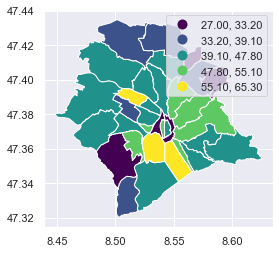

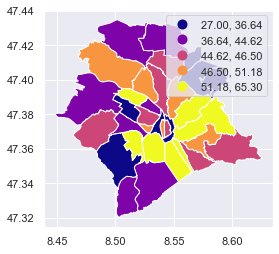

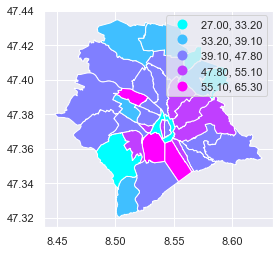

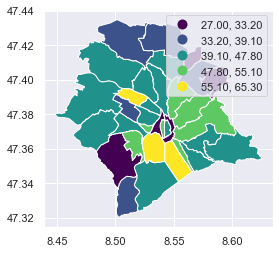

In [252]:
# Plot by StatQuartiere

stadtquartiere_shapes_joined.plot(column='SteuerEinkommen_p50', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='SteuerEinkommen_p50', cmap='plasma', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html
stadtquartiere_shapes_joined.plot(column='SteuerEinkommen_p50', cmap='cool', scheme='fisherjenks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

stadtquartiere_shapes_joined.plot(column='SteuerEinkommen_p50', cmap='viridis', scheme='natural_breaks', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

----------------------------------------------------------------------------------------

#Link https://automating-gis-processes.github.io/site/notebooks/L5/interactive-map-folium.html

# Create a Map instance
m = folium.Map(location=[60.25, 24.8], tiles = 'cartodbpositron', zoom_start=10, control_scale=True)

# Plot a choropleth map
# Notice: 'geoid' column that we created earlier needs to be assigned always as the first column
folium.Choropleth(
    geo_data=data,
    name='Population in 2018',
    data=data,
    columns=['geoid', 'pop18'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    line_color='white',
    line_weight=0,
    highlight=False,
    smooth_factor=1.0,
    #threshold_scale=[100, 250, 500, 1000, 2000],
    legend_name= 'Population in Helsinki').add_to(m)

#Show map
m

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html